We scanned 10 fishes for Carolina, let's preview them.

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client
client = Client()
# Then go to http://localhost:8787/status
from numcodecs import Blosc
import skimage
from tqdm import notebook

C:\ProgramData\Anaconda3\lib\site-packages\distributed\node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52385 instead
  http_address["port"], self.http_server.port


In [2]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:52385/status"


In [3]:
# # https://stackoverflow.com/a/62242245/323100
# import warnings
# warnings.filterwarnings('ignore')

In [4]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [5]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [6]:
# Display all plots identically
lines = 2
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [7]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Zebrafish_Carolina_Muscles')
print('We are loading all the data from %s' % Root)

We are loading all the data from F:\Zebrafish_Carolina_Muscles


In [8]:
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})

In [9]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    pixelsize = numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [10]:
def get_ringartefact(logfile):
    """Get the ring artefact correction from the  scan log file"""
    ringartefactcorrection = numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Ring Artifact' in line:
                ringartefactcorrection = int(line.split('=')[1])
    return(ringartefactcorrection)

In [11]:
def get_reconstruction_grayvalue(logfile):
    """How did we map the brightness of the reconstructions?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [12]:
def get_beamhardening(logfile):
    """Get the beamhardening correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Hardening' in line:
                beamhardeningcorrection = int(line.split('=')[1])
    return(beamhardeningcorrection)

In [13]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [14]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to P:\Documents\Zebrafish-Carolina\Output\3ee710c


In [15]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [16]:
# Get *all* log files in the root folder
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'),
                                               recursive=True))]

In [17]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [18]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [19]:
print('We found %s subfolders in %s' % (len(Data), Root))

We found 10 subfolders in F:\Zebrafish_Carolina_Muscles


In [20]:
Data['Sample'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]

In [21]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [22]:
# Drop samples which have not been reconstructed yet
# Based on https://stackoverflow.com/a/13851602
for sample in Data[Data['Number of reconstructions'] == 0]['Sample']:
    print('%s has not been reconstructed yet, we remove it from our data temporarily' % sample)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

We have 10 folders with reconstructions


In [23]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [get_ringartefact(log) for log in Data['LogFile']]
Data['Beamhardening'] = [get_beamhardening(log) for log in Data['LogFile']]
Data['ReconstructionGrayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]

In [24]:
# Are the samples reconstructed equally?
Data

,LogFile,Folder,Sample,Reconstructions,Number of reconstructions,Voxelsize,RingartefactCorrection,Beamhardening,ReconstructionGrayvalue
0,F:\Zebrafish_Carolina_Muscles\ko01\rec\ko01_re...,F:\Zebrafish_Carolina_Muscles\ko01\rec,ko01,[F:\Zebrafish_Carolina_Muscles\ko01\rec\ko01_r...,4303,7.99995,7,0,0.1
1,F:\Zebrafish_Carolina_Muscles\ko02\rec\ko02_re...,F:\Zebrafish_Carolina_Muscles\ko02\rec,ko02,[F:\Zebrafish_Carolina_Muscles\ko02\rec\ko02_r...,3659,7.99995,7,0,0.1
2,F:\Zebrafish_Carolina_Muscles\ko03\rec\ko03_re...,F:\Zebrafish_Carolina_Muscles\ko03\rec,ko03,[F:\Zebrafish_Carolina_Muscles\ko03\rec\ko03_r...,3715,7.99995,7,0,0.1
3,F:\Zebrafish_Carolina_Muscles\ko04\rec\ko04_re...,F:\Zebrafish_Carolina_Muscles\ko04\rec,ko04,[F:\Zebrafish_Carolina_Muscles\ko04\rec\ko04_r...,4303,7.99995,7,0,0.1
4,F:\Zebrafish_Carolina_Muscles\ko05\rec\ko05_re...,F:\Zebrafish_Carolina_Muscles\ko05\rec,ko05,[F:\Zebrafish_Carolina_Muscles\ko05\rec\ko05_r...,3361,7.99995,7,0,0.1
5,F:\Zebrafish_Carolina_Muscles\wt01\rec\wt01_re...,F:\Zebrafish_Carolina_Muscles\wt01\rec,wt01,[F:\Zebrafish_Carolina_Muscles\wt01\rec\wt01_r...,3846,7.99995,7,0,0.1
6,F:\Zebrafish_Carolina_Muscles\wt02\rec\wt02_re...,F:\Zebrafish_Carolina_Muscles\wt02\rec,wt02,[F:\Zebrafish_Carolina_Muscles\wt02\rec\wt02_r...,4303,7.99995,7,0,0.1
7,F:\Zebrafish_Carolina_Muscles\wt03\rec\wt03_re...,F:\Zebrafish_Carolina_Muscles\wt03\rec,wt03,[F:\Zebrafish_Carolina_Muscles\wt03\rec\wt03_r...,3856,7.99995,7,0,0.1
8,F:\Zebrafish_Carolina_Muscles\wt04\rec\wt04_re...,F:\Zebrafish_Carolina_Muscles\wt04\rec,wt04,[F:\Zebrafish_Carolina_Muscles\wt04\rec\wt04_r...,3951,7.99995,7,0,0.1
9,F:\Zebrafish_Carolina_Muscles\wt05\rec\wt05_re...,F:\Zebrafish_Carolina_Muscles\wt05\rec,wt05,[F:\Zebrafish_Carolina_Muscles\wt05\rec\wt05_r...,3801,7.99995,7,0,0.1


In [25]:
# Check voxel sizes (*rounded* to two after-comma values)
# If different, spit out which values
print('We scanned all samples with', end=' ')
if len(Data['Voxelsize'].round(2).unique())>1:
    print('%s different voxel sizes' % len(Data['Voxelsize'].round(2).unique()))
    for vs in sorted(Data['Voxelsize'].round(2).unique()):
        print('-', vs, 'um for Samples ', end='')
        for c, row in Data.iterrows():
            if float(vs) == round(row['Voxelsize'],2):
                print(row.Sample, end=', ')
        print('')
else:
    print('equal voxel size, namely %s um.' % Data['Voxelsize'].unique()[0])

We scanned all samples with equal voxel size, namely 7.99995 um.


In [26]:
# Check beam hardening
# If different, spit out which values
print('We reconstructed all samples with', end=' ')
if len(Data['RingartefactCorrection'].round(2).unique())>1:
    print('%s different RAC' % len(Data['RingartefactCorrection'].round(2).unique()))
    for rac in sorted(Data['RingartefactCorrection']):
        print('-', rac, 'for Samples ', end='')
        for c, row in Data.iterrows():
            print(row.Sample, end=', ')
        print('')
else:
    print('equal ringartefact correction, namely %s.' % Data['RingartefactCorrection'].unique()[0])

We reconstructed all samples with equal ringartefact correction, namely 7.


In [27]:
# Check beam hardening
# If different, spit out which values
print('We reconstructed all samples with', end=' ')
if len(Data['Beamhardening'].round(2).unique())>1:
    print('%s different beam-hardening correction' % len(Data['Beamhardening'].round(2).unique()))
    for bh in sorted(Data['Beamhardening']):
        print('-', bh, 'for Samples ', end='')
        for c, row in Data.iterrows():
            print(row.Sample, end=', ')
        print('')
else:
    print('equal beam-hardening correction, namely %s.' % Data['Beamhardening'].unique()[0])

We reconstructed all samples with equal beam-hardening correction, namely 0.


In [28]:
# Check reconstruction gray value
# If different, spit out which values
print('We reconstructed all samples with', end=' ')
if len(Data['ReconstructionGrayvalue'].round(2).unique())>1:
    print('%s different max. grayvalue' % len(Data['ReconstructionGrayvalue']))
    for recgv in sorted(Data['ReconstructionGrayvalue']):
        print('-', recgv, ' for Samples ', end='')
        for c, row in Data.iterrows():
            print(row.Sample, end=', ')
        print('')
else:
    print('equal max. gray value, namely %s.' % Data['ReconstructionGrayvalue'].unique()[0])

We reconstructed all samples with equal max. gray value, namely 0.1.


In [29]:
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, '*_spr.bmp'))) for f in Data['Folder']]
Data['PreviewImage'] = [imageio.imread(pip[0])
                        if pip
                        else numpy.random.random((100, 100)) for pip in Data['PreviewImagePath']]

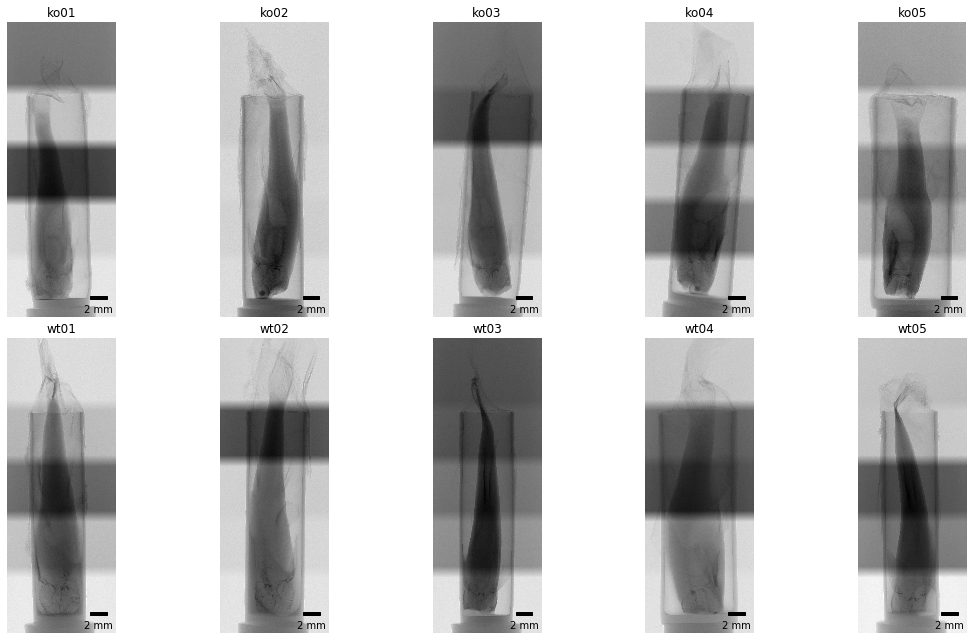

In [30]:
for c,row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row.PreviewImage)
    plt.title(row.Sample)
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color='black'))
    plt.axis('off')
plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.show()

In [31]:
# Convert all reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(os.path.dirname(f),
                                      fish + '_rec.zarr') for f, fish in zip(Data['Folder'],
                                                                             Data['Sample'])]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Converting reconstructions to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRec']):
        print('%2s/%2s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                        len(Data),
                                                                        row['Number of reconstructions'],
                                                                        row['OutputNameRec'][len(Root)+1:]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], '*rec*.png'))
        Reconstructions.to_zarr(row['OutputNameRec'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))

In [32]:
# Load the reconstructions a zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [33]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [34]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [35]:
Data

,LogFile,Folder,Sample,Reconstructions,Number of reconstructions,Voxelsize,RingartefactCorrection,Beamhardening,ReconstructionGrayvalue,PreviewImagePath,PreviewImage,OutputNameRec,Size
0,F:\Zebrafish_Carolina_Muscles\ko01\rec\ko01_re...,F:\Zebrafish_Carolina_Muscles\ko01\rec,ko01,[F:\Zebrafish_Carolina_Muscles\ko01\rec\ko01_r...,4303,7.99995,7,0,0.1,[F:\Zebrafish_Carolina_Muscles\ko01\rec\ko01_r...,"[[135, 135, 135, 134, 135, 134, 135, 135, 135,...",F:\Zebrafish_Carolina_Muscles\ko01\ko01_rec.zarr,"(4303, 1632, 1632)"
1,F:\Zebrafish_Carolina_Muscles\ko02\rec\ko02_re...,F:\Zebrafish_Carolina_Muscles\ko02\rec,ko02,[F:\Zebrafish_Carolina_Muscles\ko02\rec\ko02_r...,3659,7.99995,7,0,0.1,[F:\Zebrafish_Carolina_Muscles\ko02\rec\ko02_r...,"[[207, 207, 207, 210, 208, 207, 208, 208, 207,...",F:\Zebrafish_Carolina_Muscles\ko02\ko02_rec.zarr,"(3659, 1632, 1632)"
2,F:\Zebrafish_Carolina_Muscles\ko03\rec\ko03_re...,F:\Zebrafish_Carolina_Muscles\ko03\rec,ko03,[F:\Zebrafish_Carolina_Muscles\ko03\rec\ko03_r...,3715,7.99995,7,0,0.1,[F:\Zebrafish_Carolina_Muscles\ko03\rec\ko03_r...,"[[133, 133, 133, 136, 138, 137, 137, 136, 135,...",F:\Zebrafish_Carolina_Muscles\ko03\ko03_rec.zarr,"(3715, 888, 1212)"
3,F:\Zebrafish_Carolina_Muscles\ko04\rec\ko04_re...,F:\Zebrafish_Carolina_Muscles\ko04\rec,ko04,[F:\Zebrafish_Carolina_Muscles\ko04\rec\ko04_r...,4303,7.99995,7,0,0.1,[F:\Zebrafish_Carolina_Muscles\ko04\rec\ko04_r...,"[[202, 202, 202, 205, 208, 206, 203, 202, 201,...",F:\Zebrafish_Carolina_Muscles\ko04\ko04_rec.zarr,"(4303, 1024, 1500)"
4,F:\Zebrafish_Carolina_Muscles\ko05\rec\ko05_re...,F:\Zebrafish_Carolina_Muscles\ko05\rec,ko05,[F:\Zebrafish_Carolina_Muscles\ko05\rec\ko05_r...,3361,7.99995,7,0,0.1,[F:\Zebrafish_Carolina_Muscles\ko05\rec\ko05_r...,"[[174, 174, 174, 176, 177, 178, 174, 173, 171,...",F:\Zebrafish_Carolina_Muscles\ko05\ko05_rec.zarr,"(3361, 1080, 1212)"
5,F:\Zebrafish_Carolina_Muscles\wt01\rec\wt01_re...,F:\Zebrafish_Carolina_Muscles\wt01\rec,wt01,[F:\Zebrafish_Carolina_Muscles\wt01\rec\wt01_r...,3846,7.99995,7,0,0.1,[F:\Zebrafish_Carolina_Muscles\wt01\rec\wt01_r...,"[[225, 225, 225, 230, 229, 226, 225, 224, 223,...",F:\Zebrafish_Carolina_Muscles\wt01\wt01_rec.zarr,"(3846, 1056, 1212)"
6,F:\Zebrafish_Carolina_Muscles\wt02\rec\wt02_re...,F:\Zebrafish_Carolina_Muscles\wt02\rec,wt02,[F:\Zebrafish_Carolina_Muscles\wt02\rec\wt02_r...,4303,7.99995,7,0,0.1,[F:\Zebrafish_Carolina_Muscles\wt02\rec\wt02_r...,"[[212, 212, 212, 215, 215, 214, 216, 217, 215,...",F:\Zebrafish_Carolina_Muscles\wt02\wt02_rec.zarr,"(4303, 888, 1212)"
7,F:\Zebrafish_Carolina_Muscles\wt03\rec\wt03_re...,F:\Zebrafish_Carolina_Muscles\wt03\rec,wt03,[F:\Zebrafish_Carolina_Muscles\wt03\rec\wt03_r...,3856,7.99995,7,0,0.1,[F:\Zebrafish_Carolina_Muscles\wt03\rec\wt03_r...,"[[121, 121, 121, 122, 126, 127, 125, 123, 123,...",F:\Zebrafish_Carolina_Muscles\wt03\wt03_rec.zarr,"(3856, 888, 1212)"
8,F:\Zebrafish_Carolina_Muscles\wt04\rec\wt04_re...,F:\Zebrafish_Carolina_Muscles\wt04\rec,wt04,[F:\Zebrafish_Carolina_Muscles\wt04\rec\wt04_r...,3951,7.99995,7,0,0.1,[F:\Zebrafish_Carolina_Muscles\wt04\rec\wt04_r...,"[[200, 200, 200, 202, 203, 203, 203, 204, 203,...",F:\Zebrafish_Carolina_Muscles\wt04\wt04_rec.zarr,"(3951, 1632, 1632)"
9,F:\Zebrafish_Carolina_Muscles\wt05\rec\wt05_re...,F:\Zebrafish_Carolina_Muscles\wt05\rec,wt05,[F:\Zebrafish_Carolina_Muscles\wt05\rec\wt05_r...,3801,7.99995,7,0,0.1,[F:\Zebrafish_Carolina_Muscles\wt05\rec\wt05_r...,"[[206, 206, 206, 210, 209, 209, 208, 208, 209,...",F:\Zebrafish_Carolina_Muscles\wt05\wt05_rec.zarr,"(3801, 1632, 1632)"


In [36]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc='Fish %s' % row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.Middle.%s.png' % (row['Sample'],
                                                         direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

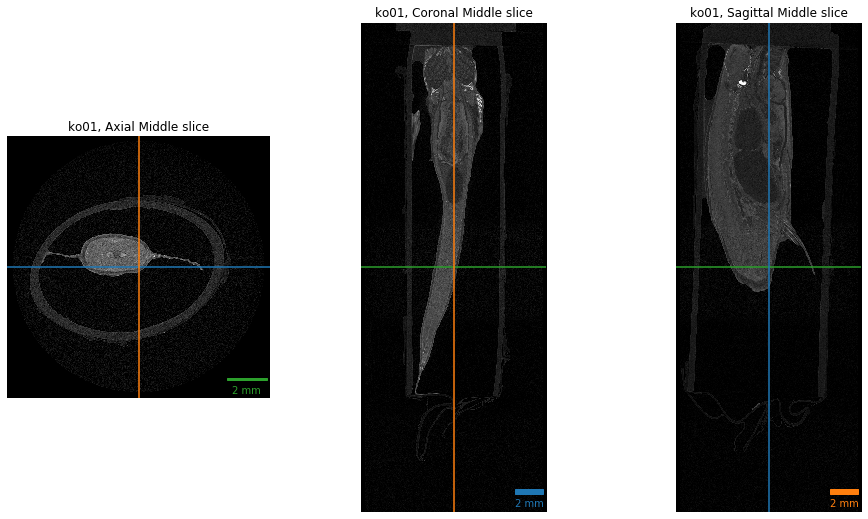

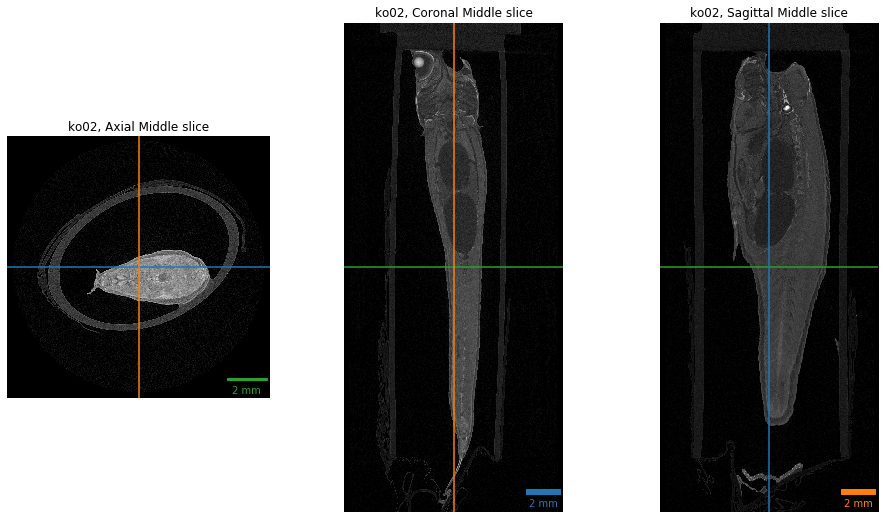

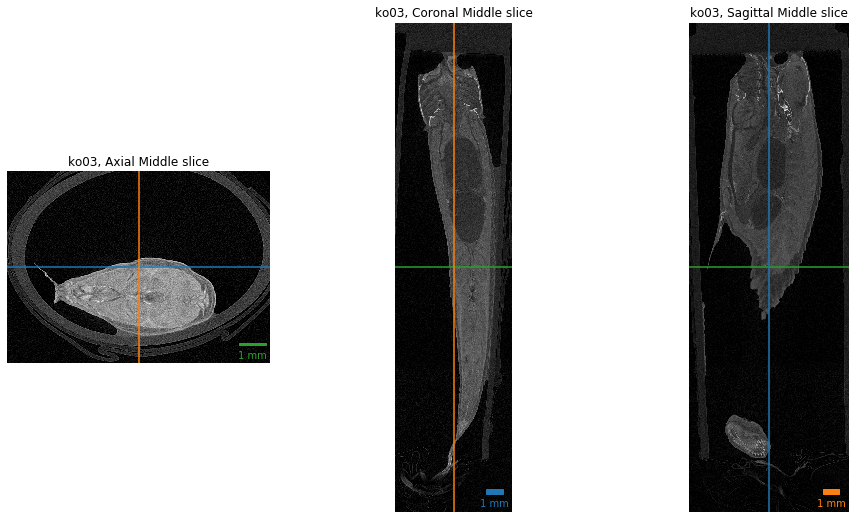

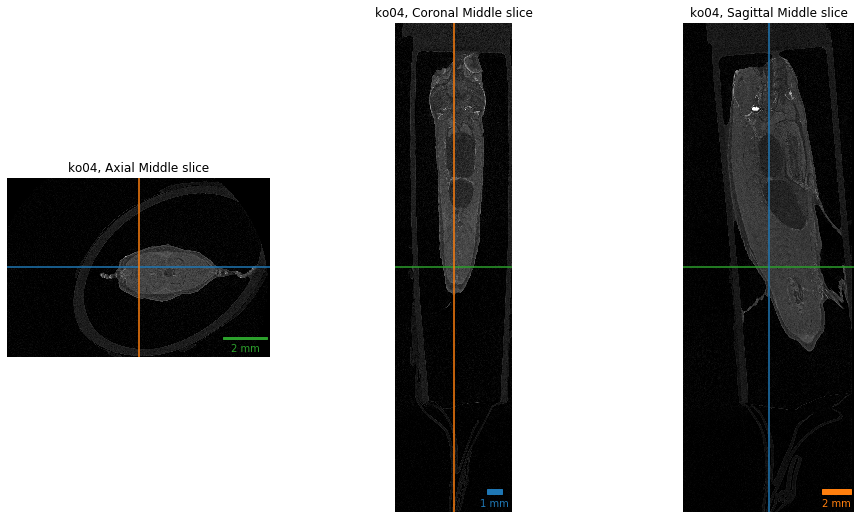

In [ ]:
# Show middle slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving middle images overview', total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.MiddleSlices.png' % row['Sample'])    
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Mid_' + direction])
        if d==0:
            plt.axhline(row.Size[1]//2, c=seaborn.color_palette()[0])
            plt.axvline(row.Size[2]//2, c=seaborn.color_palette()[1])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[2]))
        elif d==1:
            plt.axhline(row.Size[0]//2, c=seaborn.color_palette()[2])
            plt.axvline(row.Size[d]//2, c=seaborn.color_palette()[1])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[0]))
        else:
            plt.axhline(row.Size[0]//2, c=seaborn.color_palette()[2])
            plt.axvline(row.Size[d]//2, c=seaborn.color_palette()[0])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[1]))
        plt.title('%s, %s' % (row['Sample'],
                              direction + ' Middle slice'))
        plt.axis('off')
    if not os.path.exists(outfilepath):
        plt.savefig(outfilepath, bbox_inches='tight')
    plt.show()

In [ ]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_' + direction].astype('uint8'))

In [ ]:
# Show MIP slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving middle images overview', total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']), row['Sample'] + '.MIPs.png')
#     if not os.path.exists(outfilepath):       
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s, %s' % (row['Sample'],
                              direction + ' MIP'))
        plt.axis('off')
    plt.savefig(outfilepath, bbox_inches='tight')
    plt.show()

In [ ]:
print('Done with the preparation!')